# TorchVision 0.3 Object Detection finetuning tutorial

For this tutorial, we will be finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model in the [*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/). It contains 170 images with 345 instances of pedestrians, and we will use it to illustrate how to use the new features in torchvision in order to train an instance segmentation model on a custom dataset.

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [1]:
%%bash

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Could not build wheels for cython, since package 'wheel' is not installed.
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-yii7w68p
Could not build wheels for pycocotools, since package 'wheel' is not installed.
Could not build wheels for setuptools, since package 'wheel' is not installed.
Could not build wheels for cython, since package 'wheel' is not installed.
Could not build wheels for matplotlib, since package 'wheel' is not installed.
Could not build wheels for cycler, since package 'wheel' is not installed.
Could not build wheels for python-dateutil, since package 'wheel' is not installed.
Could not build wheels for numpy, since package 'wheel' is not installed.
Could not build wheels for kiwisolver, since package 'wheel' is not installed.
Could not build wheels for pyparsing, since package 'wheel' is not installed.
Could not build wheels for six, since package 'wheel' is not installed.
  Attempting uninstall: pycocotools
    Found existing installatio

In [2]:
from dataset import FoxFrameDataset

In [3]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_fox_detection_model():
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 2  # 1 class (person) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [4]:
%%bash

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [5]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
        # transforms.append(T.RandomVerticalFlip)
    return T.Compose(transforms)

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [6]:
# use our dataset and defined transformations
dataset = FoxFrameDataset('./fox_frcnn_tags.txt', get_transform(train=True))
dataset_test = FoxFrameDataset('./fox_frcnn_tags.txt', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_fox_detection_model()
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [8]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

x mem: 2744
Epoch: [6]  [ 80/149]  eta: 0:00:43  lr: 0.000050  loss: 0.0281 (0.0272)  loss_classifier: 0.0151 (0.0152)  loss_box_reg: 0.0090 (0.0100)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0016 (0.0018)  time: 0.6191  data: 0.0065  max mem: 2744
Epoch: [6]  [ 90/149]  eta: 0:00:36  lr: 0.000050  loss: 0.0242 (0.0270)  loss_classifier: 0.0152 (0.0152)  loss_box_reg: 0.0083 (0.0098)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0014 (0.0018)  time: 0.6183  data: 0.0066  max mem: 2744
Epoch: [6]  [100/149]  eta: 0:00:30  lr: 0.000050  loss: 0.0237 (0.0270)  loss_classifier: 0.0144 (0.0152)  loss_box_reg: 0.0076 (0.0099)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0015 (0.0019)  time: 0.6176  data: 0.0067  max mem: 2744
Epoch: [6]  [110/149]  eta: 0:00:24  lr: 0.000050  loss: 0.0239 (0.0276)  loss_classifier: 0.0143 (0.0154)  loss_box_reg: 0.0077 (0.0100)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0021 (0.0019)  time: 0.6177  data: 0.0067  ma

Now that training has finished, let's have a look at what it actually predicts in a test image

In [20]:
# pick one image from the test set
from PIL import Image
img, target = dataset_test[0]
to_tensor = T.ToTensor()
img = Image.open('./UXVa-0VsxOQ.001.jpg')
img_tensor, target = to_tensor(img, target)
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img_tensor.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [21]:
prediction

[{'boxes': tensor([[243.7558, 311.8545, 277.8635, 348.8309]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.0759], device='cuda:0')}]

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

In [22]:
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
im = Image.fromarray(img_tensor.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

tensor([243.7558, 311.8545, 277.8635, 348.8309], device='cuda:0')


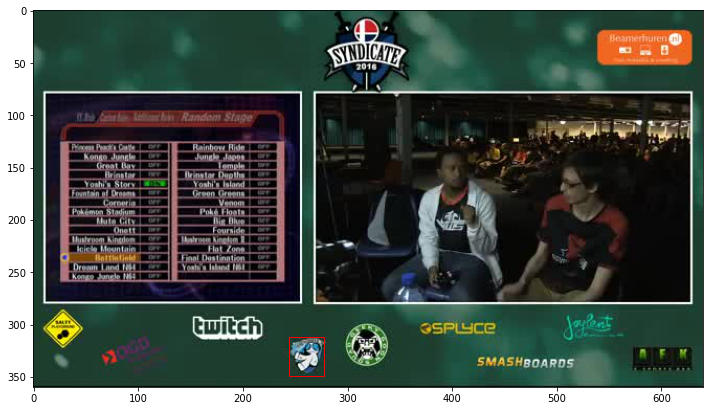

In [23]:
box = prediction[0]['boxes'][0]
fig, ax = plt.subplots(1, figsize=(12,8))
ax.imshow(im)
print(box)
[min_x, min_y, max_x, max_y] = box.tolist()
rect = patches.Rectangle((min_x, min_y), max_x - min_x, max_y-min_y, linewidth=1, edgecolor='r',facecolor='none')
ax.add_patch(rect)

Looks pretty good!

## Wrapping up

In this tutorial, you have learned how to create your own training pipeline for instance segmentation models, on a custom dataset.
For that, you wrote a `torch.utils.data.Dataset` class that returns the images and the ground truth boxes and segmentation masks. You also leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-gpu training, check `references/detection/train.py`, which is present in the [torchvision GitHub repo](https://github.com/pytorch/vision/tree/v0.3.0/references/detection). 



In [24]:
torch.save(model.state_dict(), "fox_detector.pytorch")